# Introduction to Python and Natural Language Technologies

__Lecture 8, Sequence modeling__

__March 30, 2021__

__Judit Ács__

# Agenda

1. Overview of sequence modeling
    - Sequence elements
    - Types of models
    - Some applications
2. A bare bone sequence classification example
    - Cover the details of modeling and training
    - Data preparation with Pandas
    - Training on a small task that runs quickly on a laptop CPU 
    - Use advanced Python features instead of `torchtext`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

Standard `torch` imports:

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Sequence elements

We deal with sequences in NLP:
- a token is a sequence of characters/morphemes
- a sentence is a sequence of tokens
- a paragraph is a sequence of sentences
- a dialogue is a sequence of utterances
- etc.

What are the elements of these sequences?

## Words

Pros:

- More or less well-defined in most languages
- Relatively short sequences (a sentence is rarely longer than 30 tokens)

Cons:
- Difficult tokenization in some languages
- Large vocabulary (100,000+ easily)
- Out-of-vocabulary words are always there regardless of the size of the vocabulary
- Many rare words
    - Hapax: a word that only appears once in the dataset.

## Characters

Pros:
- Smaller vocabulary although logographic writing systems (Chinese and Japanese) have thousands of characters
- Easy tokenization
- Well defined: Unicode symbols

Cons:
- Long sequences
- Too fine-grained, token level information is lost

## Subwords

- Multiple characters but smaller than words
- Modern language models use subword vocabularies
- We will cover these next week

# Sequence classification

Assign a single label to the full sequence:

<img src="img/tikz/abstract_sequence_classification.png" width="350" />

__Applications__

- Topic classification (AG News dataset from Lab 7)
- Sentiment analysis: is this sentence or paragraph a positive (1) or a negative (0) review?

<img src="img/tikz/example_sequence_classification.png" width="500" />

# Sequence tagging

Assign a label to each element of the sequence:

<img src="img/tikz/abstract_sequence_tagging.png">

__Applications__

- part-of-speech tagging
- named entity recognition (NER)

<img src="img/tikz/example_sequence_tagging.png" >

# Seq2seq

<img src="img/tikz/abstract_seq2seq.png" width=600px>

- Maps a source sequence to a target sequence
    - Arbitrary length
    
- Two steps:
    1. Encode: create a representation of the source
    2. Decode: generate the target representation
        - autoregressive: generate tokens from left-to-right one-by-one (condition on the left context)
        
- Usually implemented as two separate neural networks for example:
    - The encoder is a bidirectional LSTM
    - The decoder is a unidirectional LSTM
    
- Applications:
    - Neural machine translation
    - Morphological inflection

# Attention

Seq2seq performs poorly in its naive form since the decoder has to generate the whole output based on a single hidden vector that represents the full input sequence.

**Attention** gives peak into the input sequence [image source](https://aihub.cloud.google.com/u/0/p/products%2F024b89fd-9bc8-4c24-b8a8-e347479f3270):
    
<img src="img/dl/attention_mechanism.jpg" width=600px>

# Other tasks

There are many other NLP tasks that are solved with some combination of the above models.

- Sentence pair classification: the same as sequence classification except we assign a label to a __pair__ of sentences
    - paraphrase identification
- Span level tasks
- Tree-based tasks
    - Universal Dependencies (Lecture 10)

# Sequence classification example

We will now train a sequence classification model on Hungarian morphology. This model can be trained on a laptop CPU.

## Backpropagation


Neural networks are usually trained with the [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algorithm.

The data flow in neural networks implicitly defines a **computation graph**, this is called **forward pass**.

The output is compared against the ground truth or label and the difference or cost is quantified by **loss function** also called **cost function**.

If the loss function is differentiable with respect to the parameters, we can compute the gradient w.r.t. to all parameters i.e. we can quantify 'how responsible' a parameter is for the loss using the chain rule. This is called **backpropagation**.

An optimizer then updates the parameters. The update is proportional to the gradient. This is called **gradient descent**.

More information: [Backpropagation chapter](https://www.deeplearningbook.org/contents/mlp.html#pf25) from [Deep Learning](https://www.deeplearningbook.org/) by Goodfellow, Bengio and Courville

We will now discuss the building blocks of the sequence classifier.

## `nn.Embedding`

`nn.Embedding` maps integers to continuous vectors. Its mandatory parameters are:
- `num_embeddings`: the size of the vocabulary
- `embedding_dim`: the size of the embedding

In [16]:
embedding = nn.Embedding(5, 3) # (5,3) specifies the num_embedding and embedding_dim respectively, they are hyperparameters => we can specify them by hand.
                               # after this command, the 'embedding' already contains 5 row vectors
                               # and each of row vector, contains 3 random numbers. 
                               # the number of row vetors of the embedding is NOT the number of words in a sentence which we would consider as input for the lstm model. 

embedding(torch.LongTensor([1,4])) # some how like magic functions, callable, this command creates another matrix with its row vectors taken from the 'embedding'
                                   # THE RESULT MATRIX has 2 vectors which are taken from the 'embedding', the first vector is the first row vector of the 'embedding'
                                   # the second vector is the 4th row vector of the 'embedding' 
                                   # 1 and 4 are all indexes of the embedding (the 'embedding' object has num_embedding is 5 => the range is 5 => the indexes from 0 to 4)
                                   # results: [[ 1.1923,  0.0404,  1.4719],
                                   # [-0.8079, -0.7790,  0.2477]],...] 
                                   # [ 1.1923,  0.0404,  1.4719] shows the first element (because the index is 1) of the 'embedding', it has 3 columns because the embedding_size is 3.
                                   # [-0.8079, -0.7790,  0.2477] shows the fourth element (because the index is 4) of the 'embedding', it has 3 columns because the embedding_size is 3.

embedding(torch.LongTensor([1,4,1,1])) # this creates a matrix of 4 vectors,
                                       # the first, third and fourth vectors have their values as the first row vector of 'embedding'
                                       # the second has its values as the 4th row vector.
# embedding(torch.LongTensor([1, 5]))  # raises IndexError because 5 is out of range, our specified index of 'embedding' is (5,3), so the vocab size is 5 => the index is from 0 to 4

tensor([[-0.0556,  0.4509, -0.8940],
        [ 0.8215, -0.9376,  0.7264],
        [-0.0556,  0.4509, -0.8940],
        [-0.0556,  0.4509, -0.8940]], grad_fn=<EmbeddingBackward>)

Works with higher order tensors:

In [17]:
input_tensor = torch.LongTensor(
    [[1, 2], [0, 1], [1, 2], [0, 1], [0, 1]]
)
emb = embedding(input_tensor)
print(f"{input_tensor.size() = }")
print(f"{emb.size() = }")
emb

input_tensor.size() = torch.Size([5, 2])
emb.size() = torch.Size([5, 2, 3])


tensor([[[-0.0556,  0.4509, -0.8940],
         [ 2.8806,  0.3378, -0.7264]],

        [[-1.3386,  0.1491, -0.6072],
         [-0.0556,  0.4509, -0.8940]],

        [[-0.0556,  0.4509, -0.8940],
         [ 2.8806,  0.3378, -0.7264]],

        [[-1.3386,  0.1491, -0.6072],
         [-0.0556,  0.4509, -0.8940]],

        [[-1.3386,  0.1491, -0.6072],
         [-0.0556,  0.4509, -0.8940]]], grad_fn=<EmbeddingBackward>)

The embedding's parameters can be listed with:

In [18]:
# the values in each embedding row vector represents a weight in the machine learning (deeplearning) model,
# which is updated by backpropagation procedure. 

for pname, param in embedding.named_parameters():
    print(pname, param.size())

weight torch.Size([5, 3])


## `nn.LSTM`

LSTM is the most popular recurrent cell that takes a sequence as an input and processes it one by one while updating its hidden state. Its parameters are (from [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM)):
- `input_size`: The number of expected features in the input x
- `hidden_size`: The number of features in the hidden state h
- `num_layers`: Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
- `bias`: If False, then the layer does not use bias weights b_ih and b_hh. Default: True
- `batch_first`: If True, then the input and output tensors are provided as (batch, seq, feature). Default: False
- `dropout`: If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
- `bidirectional`: If True, becomes a bidirectional LSTM. Default: False


In [19]:
lstm = nn.LSTM(5, 12, num_layers=1, bidirectional=False, batch_first=True, dropout=0) # list of parameters of nn.LSTM are listed in the above cell
lstm

LSTM(5, 12, batch_first=True)

In [7]:
# these are the trained parameter of the machine learning model by backpropagation procedure.
for pname, param in lstm.named_parameters():
    print(pname, param.size())

weight_ih_l0 torch.Size([48, 5])
weight_hh_l0 torch.Size([48, 12])
bias_ih_l0 torch.Size([48])
bias_hh_l0 torch.Size([48])


Its input **must** be 3D:

In [22]:
input_tensor = torch.rand((3, 2)) # a 2D input

# with the 2D input_tensor:
#lstm(input_tensor)  # raises RunTimeError

In [23]:
# batch_size X sequence_length X input_size (The number of expected features in the input x)
# 3 X 2 X 5
input_tensor = torch.rand((3, 2, 5)) 


outputs, (h, c) = lstm(input_tensor) # 
                                     # 'outputs' is the intermedietary outputs of each step,
                                     # there are 2 steps because the sequence_length is 2  
                                     #  check the 'outputs' size: outputs.size() = torch.Size([3, 2, 12])
                                     # 3: batch size
                                     # 2: sequence_length 
                                     # 12: hidden size (number of parameters inside a lstm cell? ) of lstm.
                                     # 'h' the output weight of final (output) cell in the model made of the lstm
                                     # 'c' the output value of final (output) cell in the model made of the lstm
print(f"{outputs.size() = }")
print(f"{h.size() = }")
print(f"{c.size() = }")

outputs.size() = torch.Size([3, 2, 12])
h.size() = torch.Size([1, 3, 12])
c.size() = torch.Size([1, 3, 12])


In practice we generally use bidirectional LSTMs, which are implemented as two unidirectional LSTMs.

`h` and `c` are now the final states of both unidirectional LSTMs:

In [24]:
lstm = nn.LSTM(5, 12, num_layers=1, bidirectional=True, batch_first=True, dropout=0)

input_tensor = torch.rand((3, 2, 5))
outputs, (h, c) = lstm(input_tensor)

#h.size() = torch.Size([2, 3, 12]); the first param is 2 because we define the bidirectional=True
                                  # it is like concatenation of 2 unidirectional LSTMs

print(f"{outputs.size() = }")
print(f"{h.size() = }")
print(f"{c.size() = }")

outputs.size() = torch.Size([3, 2, 24])
h.size() = torch.Size([2, 3, 12])
c.size() = torch.Size([2, 3, 12])


## Combining `nn.LSTM` with `nn.Embedding`

In [11]:
# model parameters
vocab_size = 10
embedding_size = 5
lstm_hidden_size = 6

embedding = nn.Embedding(vocab_size, embedding_size)
lstm = nn.LSTM(embedding_size, lstm_hidden_size, num_layers=1, bidirectional=True, batch_first=True, dropout=0)

In [12]:
# input parameters (not that these are independent of the model)
batch_size = 3
sequence_length = 4

input_ids = torch.randint(vocab_size, (batch_size, sequence_length))
input_ids

tensor([[9, 5, 6, 0],
        [7, 7, 6, 2],
        [1, 5, 9, 1]])

In [13]:
embedded = embedding(input_ids)
outputs, (h, c) = lstm(embedded)

print(f"{input_ids.size() = }")
print(f"{embedded.size() = }")
print(f"{outputs.size() = }") #outputs.size() = torch.Size([3, 4, 12]), the 12 = 6+6, because the hidden_size is 6 and lstm is bidirectional => 6 for each direction => 2 directions are 12
print(f"{h.size() = }")
print(f"{c.size() = }")

input_ids.size() = torch.Size([3, 4])
embedded.size() = torch.Size([3, 4, 5])
outputs.size() = torch.Size([3, 4, 12])
h.size() = torch.Size([2, 3, 6])
c.size() = torch.Size([2, 3, 6])


## `nn.Linear` (another type of cell which is different from LSTM cell)

`nn.Linear` implements a matrix projection:

In [25]:
dense = nn.Linear(3, 5)
dense

Linear(in_features=3, out_features=5, bias=True)

In [26]:
for pname, param in dense.named_parameters():
    print(pname, param.size())

weight torch.Size([5, 3])
bias torch.Size([5])


In [27]:
input_tensor = torch.rand((2, 3))
output = dense(input_tensor)
print(f"{output.size() = }")

output.size() = torch.Size([2, 5])


Inner dimensions must match:

In [17]:
input_tensor = torch.rand((2, 4)) # because the input feature of the dense is 3 but here 4 is provided 
# => output = dense(input_tensor)  # raises RuntimeError

## The `LSTMClassifier` class

We can now define our own LSTM sequence classifier model.

All PyTorch modules must subclass `nn.Module` (or one of its subclasses) and call `init` before any attribute assignment.

There two methods we have to implement:
- `__init__`: defines submodules. These constitute the nodes _computation graph_.
- `forward` implements the forward pass of the module. This is how we map the input to the output. The way we pass the input through the module implicitly builds a directed graph of the submodules named _computation graph_.

The backward pass is automatically handled by PyTorch but it can be overriden by implementind the `backward` method.

In [29]:
class LSTMClassifier(nn.Module): # inherits from nn.Module, which is used to build a module in the machine learning (deeplearning) model
    def __init__(self, input_size, embedding_size, hidden_size, output_size): # output_size is number of labels (or targeted classes) we want to have
        super().__init__()
        
        # the below commands specifies all the parameters of the model:
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True, # to specify whether the firs parameter of lstm() is batch_size or sequence_length
        ) # a LSTM layer followed by a linear layer which is specified below:
        
        # the linear layer:
        self.dense = nn.Linear(hidden_size * 2, output_size)
        
    def forward(self, sequences):
        # sequences: batch_size X sequence_length
        embedded = self.embedding(sequences)
        
        # lstm_outputs: batch_size X sequence_length X 2*hidden_size
        # h: 2 X batch_size X hidden_size
        # c: 2 X batch_size X hidden_size
        lstm_outputs, (h, c) = self.lstm(embedded)
        
        # h: batch_size X 2*hidden_size
        h = torch.cat((h[0], h[1]), dim=-1)
        
        # output: batch_size X output_size
        output = self.dense(h)
        return output
        
        
toy_classifier = LSTMClassifier(3, 110, 5, 4) # 4 specifies how many columns (labels) we will have in the output matrix
toy_input = torch.LongTensor([
    [0, 1, 0, 2], # the same as the second row vector => their outputs must be the same
    [0, 1, 0, 2],
    [0, 0, 0, 2],
    [1, 1, 2, 0],
])
toy_classifier(toy_input)

tensor([[-0.3148, -0.1321, -0.6120,  0.2341],
        [-0.3148, -0.1321, -0.6120,  0.2341],
        [-0.3417, -0.2198, -0.5960,  0.1149],
        [-0.3190, -0.0557, -0.3756,  0.1535]], grad_fn=<AddmmBackward>)

### Under the hood

PyTorch registers every attribute in `__init__` that is an instance of `nn.Module` in the parameters of the module:

In [30]:
for pname, param in toy_classifier.named_parameters():
    print(pname, param.size())

embedding.weight torch.Size([3, 110])
lstm.weight_ih_l0 torch.Size([20, 110])
lstm.weight_hh_l0 torch.Size([20, 5])
lstm.bias_ih_l0 torch.Size([20])
lstm.bias_hh_l0 torch.Size([20])
lstm.weight_ih_l0_reverse torch.Size([20, 110])
lstm.weight_hh_l0_reverse torch.Size([20, 5])
lstm.bias_ih_l0_reverse torch.Size([20])
lstm.bias_hh_l0_reverse torch.Size([20])
dense.weight torch.Size([4, 10])
dense.bias torch.Size([4])


This is **not** true for lists and other complex data types. PyTorch does not attempt to traverse them:

In [31]:
class SimpleModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = [nn.Linear(12, 4), nn.Linear(15, 9)]
        
for pname, param in SimpleModule().named_parameters():
    print(pname, param.size()) # prints nothing because the self.layers = [nn.Linear(12, 4), nn.Linear(15, 9)]
    # is not processed by Pytorch

The solution is `nn.ModuleList` or `nn.Sequential`:

In [32]:
class SimpleModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(12, 4), nn.Linear(15, 9)])
        
for param in SimpleModule().named_parameters():
    print(f"name: {param[0]}, size: {param[1].size()}")

name: layers.0.weight, size: torch.Size([4, 12])
name: layers.0.bias, size: torch.Size([4])
name: layers.1.weight, size: torch.Size([9, 15])
name: layers.1.bias, size: torch.Size([9])


`nn.Sequential` chains multiple modules:

In [33]:
class SimpleModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(12, 4),
            nn.ReLU(),
            nn.Linear(15, 9),
            nn.Tanh(),
        )
        
    def forward(self, input):
        out = self.layers(out)
        return out
    
        
for pname, param in SimpleModule().named_parameters():
    print(pname, param.size())

layers.0.weight torch.Size([4, 12])
layers.0.bias torch.Size([4])
layers.2.weight torch.Size([9, 15])
layers.2.bias torch.Size([9])


## Data preparation

Please run `08_Prepare_unimorph_data.ipynb` to download and preprocess the dataset for this example.

We will now train a small classifier that predicts the case of Hungarian nouns. Hungarian has a rich case system in place of prefixes used by English. Some examples are:

| Case | Hungarian | English |
| ---- | ---- | ---- |
| Nominative | ház | house |
| Instrumental | házzal | with (a) house |
| Ablative  | háztól | from at (a) house |
| Elativus  | házból | from inside (a) house |


We will train a character-level model that predicts the case based on the word form. This is an easy task since most of the time the grammatical case is obvious from the last 3 characters of the word.

Our model looks like this:

<img src="img/tikz/hungarian_case_lstm.png" width=600px>

In [34]:
train_df = pd.read_table("data/unimorph/hun_train.tsv")
dev_df = pd.read_table("data/unimorph/hun_dev.tsv")
test_df = pd.read_table("data/unimorph/hun_test.tsv")
print(len(train_df), len(dev_df), len(test_df))
train_df.head()

343484 42752 43157


,lemma,infl,tags,pos,case
0,gravitáció,gravitáción,N;ON+ESS;SG,N,ON+ESS
1,gravitáció,gravitációként,N;FRML;SG,N,FRML
2,gravitáció,gravitációkban,N;IN+ESS;PL,N,IN+ESS
3,gravitáció,gravitációkhoz,N;AT+ALL;PL,N,AT+ALL
4,gravitáció,gravitáció,N;NOM;SG,N,NOM


### Downsampling

We don't need much data to train the model, let's downsample it and train on a small subset.

In [35]:
train_df = train_df.sample(1000, random_state=1).reset_index(drop=True)
dev_df = dev_df.sample(200, random_state=1).reset_index(drop=True)
test_df = test_df.sample(200, random_state=1).reset_index(drop=True)

### Building the vocabulary

We need to map each character to an integer id. For this we need to define a `char->int` mapping that is as big as the alphabet:

In [36]:
alphabet = set()
for token in train_df.infl: # should use train set not with test set to have the most accurate assessment of our model
    alphabet |= set(token)
len(alphabet)

42

and some extra symbols:

1. PAD: used as filler symbols for shorter sequences (see later)
2. BOS: beginning-of-sequence. Indicates the start of the sequence.
2. EOS: end-of-sequence. Indicates the end of the sequence.
2. UNK: unknown. Symbols (or words) that fall out of the vocabulary are replaced with this symbol.

In [40]:
alphabet.add('<PAD>')
alphabet.add('<BOS>')
alphabet.add('<EOS>')
alphabet.add('<UNK>')

In [44]:
vocab = {symbol: i for i, symbol in enumerate(alphabet)}
len(vocab)
vocab

{'e': 0,
 'x': 1,
 'F': 2,
 'é': 3,
 'w': 4,
 'ű': 5,
 'v': 6,
 '-': 7,
 'g': 8,
 'y': 9,
 'ü': 10,
 'f': 11,
 'z': 12,
 'D': 13,
 '<BOS>': 14,
 'ú': 15,
 'í': 16,
 'P': 17,
 'r': 18,
 'a': 19,
 'c': 20,
 'd': 21,
 's': 22,
 'j': 23,
 'l': 24,
 'o': 25,
 'b': 26,
 'm': 27,
 '<PAD>': 28,
 'ö': 29,
 'á': 30,
 'h': 31,
 'i': 32,
 'C': 33,
 'ő': 34,
 'u': 35,
 ' ': 36,
 'k': 37,
 'ó': 38,
 'p': 39,
 '<EOS>': 40,
 '|': 41,
 'n': 42,
 '<UNK>': 43,
 '.': 44,
 't': 45}

In [45]:
def encode_token(token):
    ids = []
    ids.append(vocab['<BOS>'])
    # dev and test might contain characters outside the alphabet
    ids.extend(vocab.get(c, vocab['<UNK>']) for c in token)# if the word is in the vocabulary, we get its index as value, if it is not, we get UNK as value
    ids.append(vocab['<EOS>'])
    return ids

print(f"{encode_token('alma') = }") # result: [14, 19, 24, 27, 19, 40] ; 14  is the BOS and 40 is the EOS
print(f"{vocab['<UNK>'] = }")
print(f"{encode_token('ALMA') = }")

encode_token('alma') = [14, 19, 24, 27, 19, 40]
vocab['<UNK>'] = 43
encode_token('ALMA') = [14, 43, 43, 43, 43, 40]


Let's encode our dataset:

In [46]:
train_df['encoded'] = train_df.infl.apply(encode_token) # apply enode_token function for each value in the column 'infl'
dev_df['encoded'] = dev_df.infl.apply(encode_token)
test_df['encoded'] = test_df.infl.apply(encode_token)
train_df.head()

,lemma,infl,tags,pos,case,encoded
0,fülbemászó,fülbemászóként,N;FRML;SG,N,FRML,"[14, 11, 10, 24, 26, 0, 27, 30, 22, 12, 38, 37..."
1,feszültebb,feszültebbet,N;ACC;SG,N,ACC,"[14, 11, 0, 22, 12, 10, 24, 45, 0, 26, 26, 0, ..."
2,olajfa,olajfára,N;ON+ALL;SG,N,ON+ALL,"[14, 25, 24, 19, 23, 11, 30, 18, 19, 40]"
3,prostitúció,prostitúciókat,N;ACC;PL,N,ACC,"[14, 39, 18, 25, 22, 45, 32, 45, 15, 20, 32, 3..."
4,alt,alttá,N;TRANS;SG,N,TRANS,"[14, 19, 24, 45, 45, 30, 40]"


### Padding

The input sequences different in length at the moment:

<AxesSubplot:xlabel='infl', ylabel='count'>

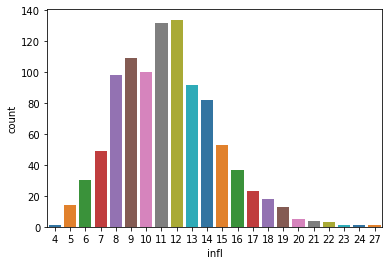

In [47]:
sns.countplot(x=train_df.infl.str.len(), palette='tab10') # find the longest sequence.

In [31]:
train_df.loc[train_df.infl.str.len().idxmax()] # # find the longest sequence exactly

lemma                              megkülönböztethetetlenség
infl                             megkülönböztethetetlenségig
tags                                               N;TERM;SG
pos                                                        N
case                                                    TERM
encoded    [12, 41, 18, 10, 16, 34, 39, 36, 17, 43, 36, 2...
Name: 161, dtype: object

We append **PAD** symbols to the shorter sequences like this:

<img src="img/tikz/padding.png">

In [48]:
maxlen = train_df.encoded.apply(len).max()
print(maxlen)

def pad_sequence(sequence):
    if len(sequence) > maxlen: # must limit every input sequence to the maximum length of the longest sequence in the train dataaset
        return sequence[:maxlen]
    return sequence + [vocab['<PAD>'] for _ in range(maxlen-len(sequence))]

print(pad_sequence([1, 2, 3, 4, 1, 2, 3]))

29
[1, 2, 3, 4, 1, 2, 3, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28]


In [51]:
train_df['padded'] = train_df.encoded.apply(pad_sequence)
dev_df['padded'] = dev_df.encoded.apply(pad_sequence)
test_df['padded'] = test_df.encoded.apply(pad_sequence)

train_df['padded'].apply(len).value_counts() # check the sanity of the pad_sequence function.

29    1000
Name: padded, dtype: int64

We will need the original lengths of each sequence later:

In [52]:
# we need to store the original sequence length for later usage ? what usage???

train_df['seqlen'] = train_df.encoded.apply(len) 
dev_df['seqlen'] = dev_df.encoded.apply(len)
test_df['seqlen'] = test_df.encoded.apply(len)

### Preparing labels

There are 18 labels:

In [53]:
label_to_id = {label: i for i, label in enumerate(train_df.case.unique())} # labels in every model must start from 0 to n-1
label_to_id

{'FRML': 0,
 'ACC': 1,
 'ON+ALL': 2,
 'TRANS': 3,
 'IN+ALL': 4,
 'AT+ALL': 5,
 'IN+ESS': 6,
 'ON+ABL': 7,
 'IN+ABL': 8,
 'INST': 9,
 'TERM': 10,
 'AT+ESS': 11,
 'PRP': 12,
 'AT+ABL': 13,
 'NOM': 14,
 'ON+ESS': 15,
 'DAT': 16}

We add a `label` column to each dataframe:

In [54]:
train_df['label'] = train_df.case.apply(lambda c: label_to_id[c])
dev_df['label'] = dev_df.case.apply(lambda c: label_to_id[c])
test_df['label'] = test_df.case.apply(lambda c: label_to_id[c])

In [55]:
train_df.head()

,lemma,infl,tags,pos,case,encoded,padded,seqlen,label
0,fülbemászó,fülbemászóként,N;FRML;SG,N,FRML,"[14, 11, 10, 24, 26, 0, 27, 30, 22, 12, 38, 37...","[14, 11, 10, 24, 26, 0, 27, 30, 22, 12, 38, 37...",16,0
1,feszültebb,feszültebbet,N;ACC;SG,N,ACC,"[14, 11, 0, 22, 12, 10, 24, 45, 0, 26, 26, 0, ...","[14, 11, 0, 22, 12, 10, 24, 45, 0, 26, 26, 0, ...",14,1
2,olajfa,olajfára,N;ON+ALL;SG,N,ON+ALL,"[14, 25, 24, 19, 23, 11, 30, 18, 19, 40]","[14, 25, 24, 19, 23, 11, 30, 18, 19, 40, 28, 2...",10,2
3,prostitúció,prostitúciókat,N;ACC;PL,N,ACC,"[14, 39, 18, 25, 22, 45, 32, 45, 15, 20, 32, 3...","[14, 39, 18, 25, 22, 45, 32, 45, 15, 20, 32, 3...",16,1
4,alt,alttá,N;TRANS;SG,N,TRANS,"[14, 19, 24, 45, 45, 30, 40]","[14, 19, 24, 45, 45, 30, 40, 28, 28, 28, 28, 2...",7,3


#### Extract input and output tensors

In [56]:
X_train = torch.from_numpy(np.array(list(train_df.padded)))
y_train = torch.LongTensor(train_df.label.values) # should convert to Tensor array due to technical reason
seqlen_train = torch.LongTensor(train_df.seqlen.values)
print(f"{X_train.size() = },\n{y_train.size() = }\n{seqlen_train.size() = }\n")

X_dev = torch.from_numpy(np.array(list(dev_df.padded)))
y_dev = torch.LongTensor(dev_df.label.values)
seqlen_dev = torch.LongTensor(dev_df.seqlen.values)
print(f"{X_dev.size() = },\n{y_dev.size() = }\n{seqlen_dev.size() = }\n")

X_test = torch.from_numpy(np.array(list(test_df.padded)))
y_test = torch.LongTensor(test_df.label.values)
seqlen_test = torch.LongTensor(test_df.seqlen.values)
print(f"{X_test.size() = },\n{y_test.size() = }\n{seqlen_test.size() = }")
# result: X_train.size() = torch.Size([1000, 29]), 29 is the length of a sequence

X_train.size() = torch.Size([1000, 29]),
y_train.size() = torch.Size([1000])
seqlen_train.size() = torch.Size([1000])

X_dev.size() = torch.Size([200, 29]),
y_dev.size() = torch.Size([200])
seqlen_dev.size() = torch.Size([200])

X_test.size() = torch.Size([200, 29]),
y_test.size() = torch.Size([200])
seqlen_test.size() = torch.Size([200])


In [57]:
seqlen_train # the first value 16 is the original length of the sequence

# why need original length? because sometimes we need the actual last element (last character or last word) in the sequence (a word or a sentence) not the PAD.
# sometimes, we do not want lstm to process the PAD either.

tensor([16, 14, 10, 16,  7, 15, 10, 20, 18, 11, 16, 12, 12, 12, 14, 11, 11, 15,
        11, 10, 15, 15, 12, 19, 12, 10, 10, 12, 13, 16, 16, 16,  9,  9, 19, 16,
        11, 16, 17, 11, 15, 17, 16, 10,  8, 11, 18, 10,  9, 14, 13, 16, 17, 15,
        18,  9, 11, 11, 11, 20, 15, 17, 11, 14,  8, 15, 12, 18,  8, 14, 20, 14,
        16, 14,  9, 16, 14, 10, 14, 13, 14, 13, 13, 19, 21, 13, 11, 20, 11, 11,
        10, 14, 14, 16, 14, 17, 10, 16, 12, 14, 13, 10, 15, 19, 14, 13, 16, 10,
        12, 12, 21, 22, 11, 14,  7, 15,  7, 10, 13, 11, 17, 10, 13,  9, 20, 10,
        11,  9, 11, 12, 13, 16, 13, 21, 15,  9, 11, 15, 15, 12, 14, 11, 15, 12,
        15, 11, 17, 13, 13, 10, 17, 12, 17, 10, 12, 13, 13, 16, 15, 16, 13, 29,
        18, 12,  8, 15,  8, 14,  9, 13, 15, 11, 21, 14, 14, 14, 12, 10, 21,  9,
        16, 11,  9, 17, 14, 17, 13,  9, 12, 14, 12, 12, 14, 16, 10, 11, 17, 18,
        16, 10, 12, 10, 13, 17, 17, 16, 14, 11, 14,  8, 16, 15,  9, 10, 17, 18,
        12, 15, 17, 13, 10, 11, 13, 10, 

## `PackedSequence` (which is used to avoid unecessary processing the PADs in the sequence)

We need to modify `LSTMClassifier` to support padding. The last output is now different for each sequence:

<img src="img/tikz/padding_last_highlight.png">

In [58]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
        )
        self.dense = nn.Linear(hidden_size * 2, output_size)
        
    # the input signature of forward changes
    def forward(self, sequences, sequence_lens):
        embedded = self.embedding(sequences)
        
        # THIS IS THE MODIFIED PART
        # returns a PackedSequence object
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded,
            sequence_lens, # to specifies the actual end of the sequence, until which lstm should consider
            enforce_sorted=False,
            batch_first=True)
        packed_outputs, (h, c) = self.lstm(packed) # h will not be the last hidden cell but ouput of the actual last hidden cell according to the real sequence length
        # extract LSTM outputs (not used here)
        lstm_outputs, lens = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        h = torch.cat((h[0], h[1]), dim=-1)
        output = self.dense(h)
        return output

## Instantiating the model

The input and the output size are determined by the alphabet and the number of labels, the rest are up to us:

In [59]:
input_size = len(vocab)
embedding_size = 30
hidden_size = 64
output_size = train_df.label.nunique() # number of unique labels

model = LSTMClassifier(input_size, embedding_size, hidden_size, output_size)
model

LSTMClassifier(
  (embedding): Embedding(46, 30)
  (lstm): LSTM(30, 64, batch_first=True, bidirectional=True)
  (dense): Linear(in_features=128, out_features=17, bias=True)
)

## Batching

Most datasets do not fit into the GPU memory so we process them in smaller chunks called _batches_.

There are many solutions for batching but it can also be implemented with simple class.

Note that the init function takes an arbitrary number of positional arguments (`*tensors`) and one mandatory keyword (`batch_size`). This class is a simplified version of batching, it lacks many features such as shuffling or sorting by sequence length.

In [67]:
class BatchedIterator:
    def __init__(self, *tensors, batch_size):
        # all tensors must have the same first dimension
        assert len(set(len(tensor) for tensor in tensors)) == 1 # make sure every tensor is the same size for batching them together.
        self.tensors = tensors
        self.batch_size = batch_size
    
    def iterate_once(self): # to iterate throug the batch size once:
        num_data = len(self.tensors[0])
        for start in range(0, num_data, self.batch_size):
            end = start + self.batch_size
            yield tuple(tensor[start:end] for tensor in self.tensors) # when the tuple is finished it goes back to the generator.
                                                                      # kind of like an interrrupt.  
            
            
print("Two tensors:")
for batch in BatchedIterator([1, 2, 3], [2, 1, 2], batch_size=2).iterate_once():
    print(batch)
# Two tensors:
#([1, 2], [2, 1]) ; [1,2] (2 values because batch_size is 2) are the first two of  [1, 2, 3], [2, 1] are the first two of [2, 1, 2]; 
#([3], [2]); [3] (the left values are not enough of 2 so it only takes 1) is the last of  [1, 2, 3], [2] are the last of [2, 1, 2]
    
    
print("\nOne tensor:")
for batch in BatchedIterator([2, 1, 2], batch_size=2).iterate_once():
    print(batch)

Two tensors:
([1, 2], [2, 1])
([3], [2])

One tensor:
([2, 1],)
([2],)


In [68]:
train_iter = BatchedIterator(X_train, seqlen_train, y_train, batch_size=501) # if batch size is smaller => more batches; if batch size is too big we could end up with only one batch.
for X, seqlens, y in train_iter.iterate_once():
    print(f"{X.size() = }, {seqlens.size() = }, {y.size() = }")

X.size() = torch.Size([501, 29]), seqlens.size() = torch.Size([501]), y.size() = torch.Size([501])
X.size() = torch.Size([499, 29]), seqlens.size() = torch.Size([499]), y.size() = torch.Size([499])


## Loss function and optimizer

The **loss function** or **cost function** quantifies cost of the model output differing from the expected target values.

The optimizer adjusts the model's parameters in accordance with the loss.

In [69]:
criterion = nn.CrossEntropyLoss() # computes the loss to propogate back to each parameters of model
optimizer = optim.Adam(model.parameters()) # actually updates the parameters of the model
                                           # Adam is a popular one.

## Sanity check (TO MAKE SURE BEFORE TRAINING, THE MODEL SHOULD BE VERY BAD)

Train and dev accuracy should be really bad without training.

Do **NOT** touch the test data while development finetuning.

In [63]:
logits = model(X_train, seqlen_train)
y = logits.argmax(axis=1) # take the highest value of the logits
accuracy = torch.sum(torch.eq(y, y_train)) / y.size(0)
print(f"Train accuracy: {accuracy:.1%}")

Train accuracy: 8.0%


In [64]:
logits = model(X_dev, seqlen_dev)
y = logits.argmax(axis=1)
accuracy = torch.sum(torch.eq(y, y_dev)) / y.size(0)
print(f"Dev accuracy: {accuracy:.1%}")

Dev accuracy: 11.0%


## Training

We collect training statistics at the end of each epochs in `metrics`.

In [65]:
num_epochs = 30
batch_size = 128

metrics = defaultdict(list)
train_iter = BatchedIterator(X_train, seqlen_train, y_train, batch_size=batch_size)

We train the model batch by batch and then evaluate it on the train and the dev data at the end of each epoch.
Since the dataset is small, we can evaluate it the whole data in one step without batching.

Note that the model should be set to **train** or **eval** mode accordingly. Stochastic steps such as dropout are disabled in **eval** mode.

In [71]:
for epoch in range(num_epochs):
    model.train()
    # Training loop
    for X_batch, seqlen_batch, y_batch in train_iter.iterate_once(): # train_iter.iterate_once() to go through a batch at a time
        y_out = model(X_batch, seqlen_batch)
        loss = criterion(y_out, y_batch) # compute the loss
        
        # to backpropagate and update the parameters of the model, these commands must be in this order
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        model.eval()  # or model.train(False)
        # Train and dev loss at the end of the epoch
        y_out = model(X_train, seqlen_train)
        train_loss = criterion(y_out, y_train).item()
        metrics['train_loss'].append(train_loss)
        labels = y_out.argmax(axis=1)
        train_accuracy = (torch.eq(y_train, labels).sum() / labels.size(0)).item()
        metrics['train_accuracy'].append(train_accuracy)

        
        # dev set is used to test the model while training
        y_out = model(X_dev, seqlen_dev)
        dev_loss = criterion(y_out, y_dev).item()
        metrics['dev_loss'].append(dev_loss)
        labels = y_out.argmax(axis=1)
        dev_accuracy = (torch.eq(y_dev, labels).sum() / labels.size(0)).item()
        metrics['dev_accuracy'].append(dev_accuracy)
    
    print(f"{epoch=} -- {train_loss=:.3f} - {train_accuracy=:.1%} - {dev_loss=:.3f} - {dev_accuracy=:.1%}")

epoch=0 -- train_loss=0.018 - train_accuracy=100.0% - dev_loss=0.114 - dev_accuracy=96.5%
epoch=1 -- train_loss=0.016 - train_accuracy=100.0% - dev_loss=0.107 - dev_accuracy=97.0%
epoch=2 -- train_loss=0.015 - train_accuracy=100.0% - dev_loss=0.117 - dev_accuracy=96.0%
epoch=3 -- train_loss=0.013 - train_accuracy=100.0% - dev_loss=0.130 - dev_accuracy=96.0%
epoch=4 -- train_loss=0.011 - train_accuracy=100.0% - dev_loss=0.124 - dev_accuracy=96.0%
epoch=5 -- train_loss=0.011 - train_accuracy=100.0% - dev_loss=0.116 - dev_accuracy=97.0%
epoch=6 -- train_loss=0.009 - train_accuracy=100.0% - dev_loss=0.109 - dev_accuracy=97.0%
epoch=7 -- train_loss=0.008 - train_accuracy=100.0% - dev_loss=0.109 - dev_accuracy=97.0%
epoch=8 -- train_loss=0.007 - train_accuracy=100.0% - dev_loss=0.112 - dev_accuracy=96.0%
epoch=9 -- train_loss=0.007 - train_accuracy=100.0% - dev_loss=0.114 - dev_accuracy=96.0%
epoch=10 -- train_loss=0.006 - train_accuracy=100.0% - dev_loss=0.115 - dev_accuracy=96.5%
epoch=11 

## Evaluation

### Training curves

<AxesSubplot:>

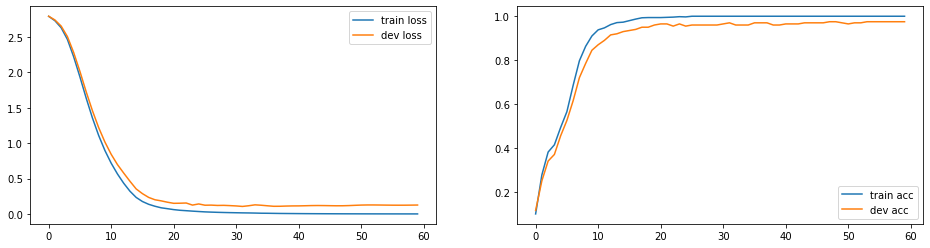

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.lineplot(data=metrics['train_loss'], ax=ax[0], label='train loss')
sns.lineplot(data=metrics['dev_loss'], ax=ax[0], label='dev loss')

sns.lineplot(data=metrics['train_accuracy'], ax=ax[1], label='train acc')
sns.lineplot(data=metrics['dev_accuracy'], ax=ax[1], label='dev acc')

## Test accuracy

In [73]:
logits = model(X_test, seqlen_test)
test_prediction = logits.argmax(axis=1)
test_accuracy = torch.sum(torch.eq(test_prediction, y_test)) / y_test.size(0)
print(f"Test accuracy: {test_accuracy:.1%}")

Test accuracy: 99.0%


## Incorrectly classified examples

In [74]:
test_df['prediction'] = test_prediction

### Recovering labels

In [75]:
id_to_label = {i: l for l, i in label_to_id.items()}
test_df['predicted_case'] = test_df['prediction'].apply(lambda id_: id_to_label[id_])

In [52]:
test_df[test_df.prediction != test_df.label][['infl', 'case', 'predicted_case']]

,infl,case,predicted_case
75,gyerekére,ON+ALL,NOM
177,sámán,NOM,ON+ESS


# Further topics

## Early stopping

Stop the training process if the development metrics no longer improve.

## Dropout

Dropout disables a random subset of neurons during each training step. It's generally set to 10-20%. Dropout usually improves generalization.

It should be disabled in evaluation steps and during inference.

## Overfitting

Fit the train set very closely but lose generalization.

[Image source](https://www.quora.com/What-are-the-key-trade-offs-between-overfitting-and-underfitting)

<img src="img/dl/overfitting.png" />

## Using the GPU

Moving things manually to the GPU:
- model: move once
- criterion: move once
- data: move one batch at a time

This should be automatically handled by your code the following way:

In [53]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [54]:
if use_cuda:
    model = model.cuda()
    criterion = criterion.cuda()

## Saving and loading models

All `nn.Modules` have a `state_dict` attribute, a dictionary of their parameters. This can be partially or fully saved with `torch.save` and loaded by `torch.load`.

[Official tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

## Inference

**Inference** is when we use the model for prediction and do not train it.

The models should be set to `eval` mode.